Estadísticas descriptivas básicas calculadas

In [11]:
import pandas as pd
import numpy as np
from pathlib import Path
from IPython.display import display, Markdown, Image
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns


# --- PASO 1: CONFIGURACIÓN DE RUTAS Y NOMBRES ---
archivos_info = {
    'clientes': 'limpios/df_clientes_limpio.csv',
    'productos': 'limpios/df_productos_limpio.csv',
    'ventas': 'limpios/df_ventas_limpio.csv',
    'detalle_ventas': 'limpios/df_detalle_ventas_limpio.csv'
}

dataframes = {}

print("--- 1. CARGANDO DATASETS INDIVIDUALMENTE ---")

for nombre, archivo in archivos_info.items():
    try:
        # ✅ Leer como CSV desde la carpeta detectada
        ruta = find_data_dir() / archivo
        df_temp = pd.read_csv(ruta)
        dataframes[nombre] = df_temp
        print(f"✅ Cargado: {nombre} ({df_temp.shape[0]} filas, {df_temp.shape[1]} columnas)")
    except FileNotFoundError:
        print(f"❌ ERROR: Archivo '{archivo}' no encontrado.")
    except Exception as e:
        print(f"❌ ERROR al procesar '{archivo}': {e}")

--- 1. CARGANDO DATASETS INDIVIDUALMENTE ---
✅ Cargado: clientes (100 filas, 5 columnas)
✅ Cargado: productos (100 filas, 4 columnas)
✅ Cargado: ventas (120 filas, 6 columnas)
✅ Cargado: detalle_ventas (343 filas, 6 columnas)


In [12]:
# Función para detectar la carpeta 'datos'
def find_data_dir(start: Path | None = None, names=('datos', 'data')) -> Path | None:
    if start is None:
        start = Path.cwd()
    start = Path(start).resolve()
    for parent in [start] + list(start.parents):
        for n in names:
            candidate = parent / n
            if candidate.is_dir():
                return candidate
    return None

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option("display.max_columns", 100)

def es_numerica(s):
    return pd.api.types.is_numeric_dtype(s)

Estadísticas descriptivas básicas calculadas

In [14]:
for nombre, df in dataframes.items():
    print(f"\n{'='*60}\n📊 ESTADÍSTICAS BÁSICAS — {nombre.upper()}\n{'='*60}")

    # Numéricas
    desc_num = df.select_dtypes(include=[np.number]).describe().T
    if not desc_num.empty:
        print("\n▶ Numéricas:")
        display(desc_num)

    # No numéricas
    desc_cat = df.select_dtypes(exclude=[np.number]).describe(include='all').T
    if not desc_cat.empty:
        print("\n▶ Categóricas / texto:")
        display(desc_cat)


📊 ESTADÍSTICAS BÁSICAS — CLIENTES

▶ Numéricas:


,count,mean,std,min,25%,50%,75%,max
id_cliente,100.0,50.5,29.011492,1.0,25.75,50.5,75.25,100.0



▶ Categóricas / texto:


,count,unique,top,freq
nombre_cliente,100,95,Olivia Perez,2
email,100,100,mariana.lopez@mail.com,1
ciudad,100,6,Rio Cuarto,23
fecha_alta,100,100,2023-01-01,1



📊 ESTADÍSTICAS BÁSICAS — PRODUCTOS

▶ Numéricas:


,count,mean,std,min,25%,50%,75%,max
id_producto,100.0,50.50,29.011492,1.0,25.75,50.5,75.25,100.0
precio_unitario,100.0,2718.55,1381.635324,272.0,1590.00,2516.0,4026.50,4982.0



▶ Categóricas / texto:


,count,unique,top,freq
nombre_producto,100,100,Coca Cola 1.5L,1
categoria,100,2,Alimentos,50



📊 ESTADÍSTICAS BÁSICAS — VENTAS

▶ Numéricas:


,count,mean,std,min,25%,50%,75%,max
id_venta,120.0,60.500000,34.785054,1.0,30.75,60.5,90.25,120.0
id_cliente,120.0,47.291667,27.854181,1.0,24.50,48.5,67.50,100.0



▶ Categóricas / texto:


,count,unique,top,freq
fecha,120,93,2024-06-19,3
nombre_cliente,120,64,Bruno Diaz,5
email,120,67,bruno.diaz@mail.com,5
medio_pago,120,4,efectivo,37



📊 ESTADÍSTICAS BÁSICAS — DETALLE_VENTAS

▶ Numéricas:


,count,mean,std,min,25%,50%,75%,max
id_venta,343.0,61.492711,34.835525,1.0,31.0,61.0,93.0,120.0
id_producto,343.0,49.139942,29.135461,1.0,23.0,47.0,76.0,100.0
cantidad,343.0,2.962099,1.366375,1.0,2.0,3.0,4.0,5.0
precio_unitario,343.0,2654.495627,1308.694720,272.0,1618.5,2512.0,3876.0,4982.0
importe,343.0,7730.078717,5265.543077,272.0,3489.0,6702.0,10231.5,24865.0



▶ Categóricas / texto:


,count,unique,top,freq
nombre_producto,343,95,Queso Rallado 150g,9


Identificación del tipo de distribución


📈 DISTRIBUCIONES — CLIENTES
- id_cliente: aprox. normal/simétrica | skew=0.00, kurtosis=-1.20


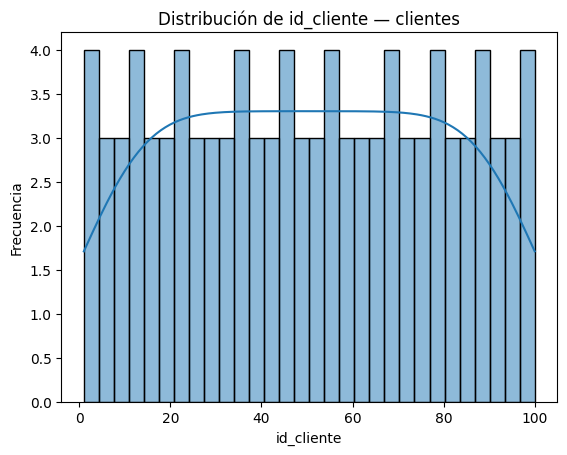


▶ Frecuencias (top 10) en categóricas:

nombre_cliente (top 10):


,conteo
nombre_cliente,
Olivia Perez,2
Agustina Martinez,2
Bruno Castro,2
Elena Rodriguez,2
Karina Acosta,2
Mariana Lopez,1
Tomas Herrera,1
Yamila Diaz,1
Camila Rodriguez,1



email (top 10):


,conteo
email,
mariana.lopez@mail.com,1
julian.alvarez@mail.com,1
zoe.flores@mail.com,1
yamila.diaz@mail.com,1
camila.rodriguez@mail.com,1
valentina.alvarez@mail.com,1
julian.diaz@mail.com,1
felipe.flores@mail.com,1
uma.torres@mail.com,1



ciudad (top 10):


,conteo
ciudad,
Rio Cuarto,23
Alta Gracia,21
Carlos Paz,15
Villa Maria,15
Cordoba,13
Mendiolaza,13



fecha_alta (top 10):


,conteo
fecha_alta,
2023-01-01,1
2023-03-05,1
2023-03-15,1
2023-03-14,1
2023-03-13,1
2023-03-12,1
2023-03-11,1
2023-03-10,1
2023-03-09,1



📈 DISTRIBUCIONES — PRODUCTOS
- id_producto: aprox. normal/simétrica | skew=0.00, kurtosis=-1.20


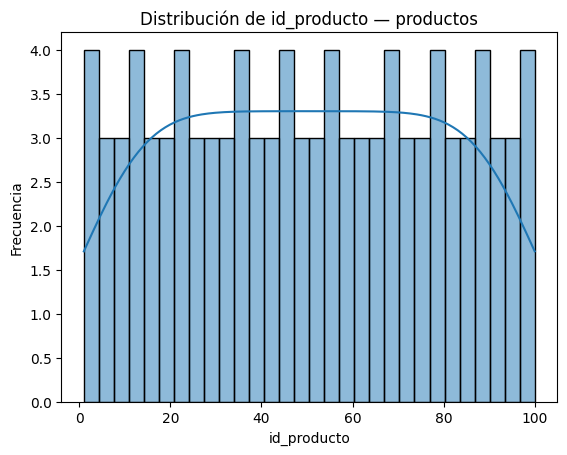

- precio_unitario: aprox. normal/simétrica | skew=0.15, kurtosis=-1.17


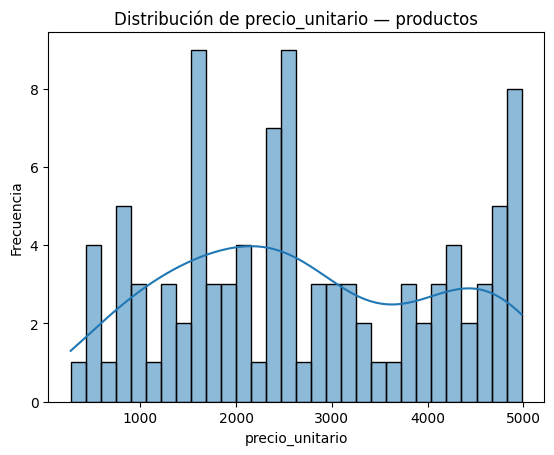


▶ Frecuencias (top 10) en categóricas:

nombre_producto (top 10):


,conteo
nombre_producto,
Coca Cola 1.5L,1
Avena Instantánea 250g,1
Whisky 750ml,1
Gin 700ml,1
Ron 700ml,1
Vodka 700ml,1
Fernet 750ml,1
Sidra 750ml,1
Vino Blanco 750ml,1



categoria (top 10):


,conteo
categoria,
Alimentos,50
Limpieza,50



📈 DISTRIBUCIONES — VENTAS
- id_venta: aprox. normal/simétrica | skew=0.00, kurtosis=-1.20


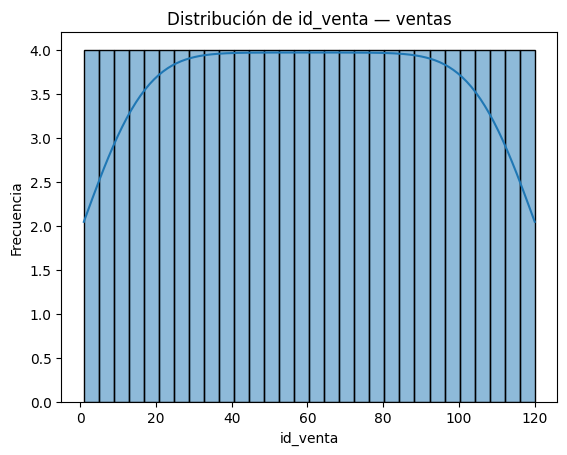

- id_cliente: aprox. normal/simétrica | skew=0.11, kurtosis=-1.00


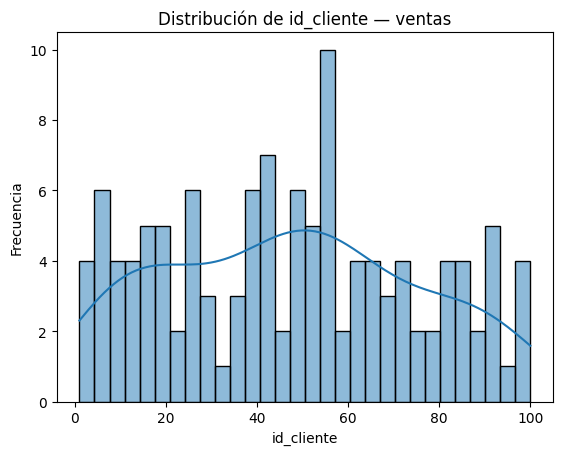


▶ Frecuencias (top 10) en categóricas:

fecha (top 10):


,conteo
fecha,
2024-06-19,3
2024-01-13,3
2024-06-11,3
2024-03-25,3
2024-02-17,2
2024-02-09,2
2024-01-19,2
2024-06-02,2
2024-01-25,2



nombre_cliente (top 10):


,conteo
nombre_cliente,
Bruno Diaz,5
Agustina Flores,4
Santiago Diaz,4
Camila Rodriguez,4
Olivia Gomez,4
Tomas Flores,4
Tomas Ruiz,3
Elena Rodriguez,3
Diego Diaz,3



email (top 10):


,conteo
email,
bruno.diaz@mail.com,5
camila.rodriguez@mail.com,4
agustina.flores@mail.com,4
tomas.flores@mail.com,4
olivia.gomez@mail.com,4
santiago.diaz@mail.com,4
tomas.ruiz@mail.com,3
diego.diaz@mail.com,3
agustina.lopez@mail.com,3



medio_pago (top 10):


,conteo
medio_pago,
efectivo,37
qr,30
transferencia,27
tarjeta,26



📈 DISTRIBUCIONES — DETALLE_VENTAS
- id_venta: aprox. normal/simétrica | skew=-0.01, kurtosis=-1.22


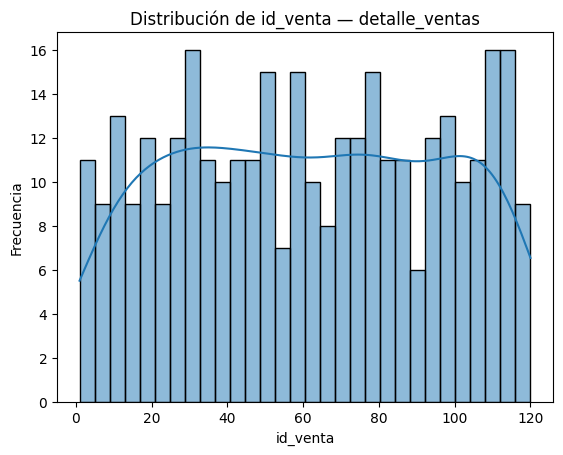

- id_producto: aprox. normal/simétrica | skew=0.07, kurtosis=-1.25


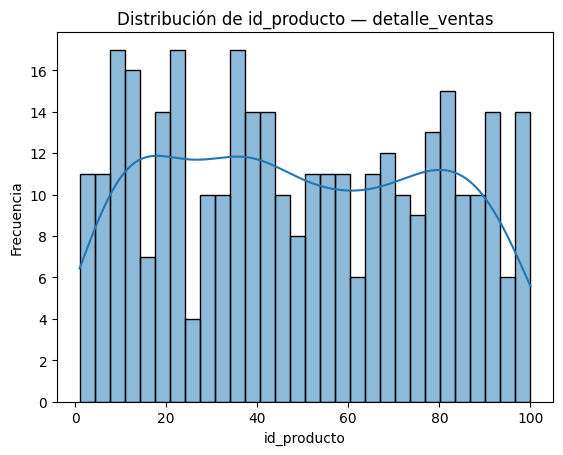

- cantidad: aprox. normal/simétrica | skew=0.06, kurtosis=-1.24


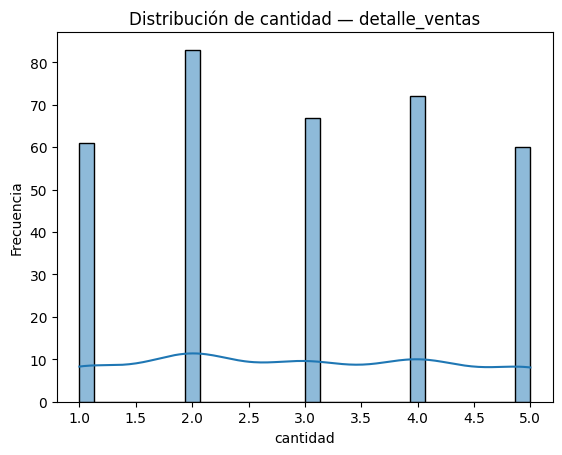

- precio_unitario: aprox. normal/simétrica | skew=0.17, kurtosis=-1.04


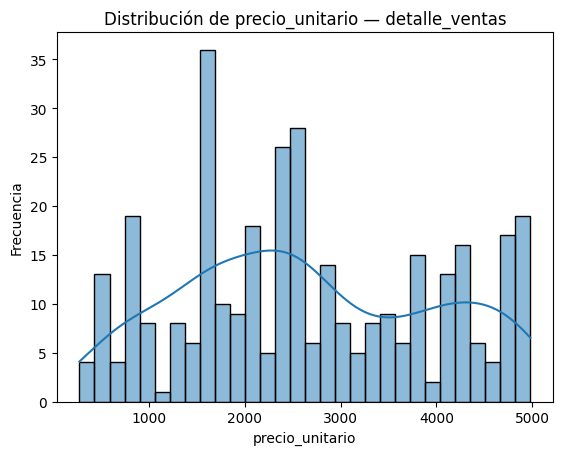

- importe: sesgo a la derecha (cola derecha) | skew=0.87, kurtosis=0.14


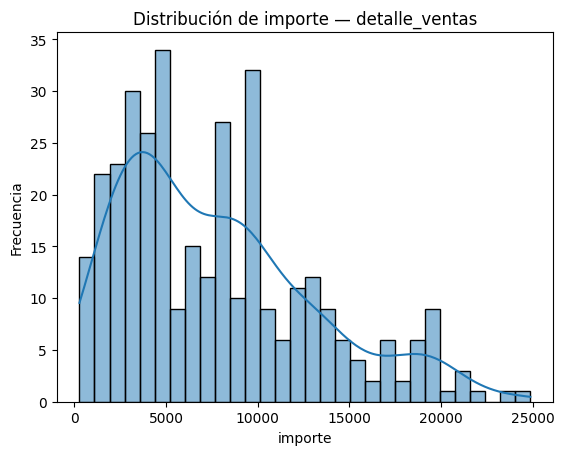


▶ Frecuencias (top 10) en categóricas:

nombre_producto (top 10):


,conteo
nombre_producto,
Queso Rallado 150g,9
Salsa de Tomate 500g,7
Desodorante Aerosol,7
Lavandina 1L,7
Mermelada de Frutilla 400g,7
Ron 700ml,7
Vino Blanco 750ml,6
Té Verde 20 saquitos,6
Desengrasante 500ml,6


In [15]:
def clasificar_distribucion(serie):
    skew = serie.skew()
    kurt = serie.kurtosis()
    if np.isnan(skew):  # todo NaN o constante
        return "sin variación / NaN", skew, kurt
    # Heurística simple por asimetría
    if abs(skew) < 0.5:
        tipo = "aprox. normal/simétrica"
    elif skew >= 0.5:
        tipo = "sesgo a la derecha (cola derecha)"
    else:
        tipo = "sesgo a la izquierda (cola izquierda)"
    return tipo, skew, kurt

for nombre, df in dataframes.items():
    print(f"\n{'='*60}\n📈 DISTRIBUCIONES — {nombre.upper()}\n{'='*60}")

    # Numéricas: clasificación + histograma
    num_cols = df.select_dtypes(include=[np.number]).columns
    for col in num_cols:
        s = df[col].dropna()
        tipo, skew, kurt = clasificar_distribucion(s)
        print(f"- {col}: {tipo} | skew={skew:.2f}, kurtosis={kurt:.2f}")

        # Histograma + KDE
        plt.figure()
        sns.histplot(s, kde=True, bins=30)
        plt.title(f"Distribución de {col} — {nombre}")
        plt.xlabel(col)
        plt.ylabel("Frecuencia")
        plt.show()

    # Categóricas: top 10 frecuencias
    cat_cols = df.select_dtypes(exclude=[np.number]).columns
    if len(cat_cols) > 0:
        print("\n▶ Frecuencias (top 10) en categóricas:")
        for col in cat_cols:
            vc = df[col].value_counts(dropna=False).head(10)
            print(f"\n{col} (top 10):")
            display(vc.to_frame("conteo"))


Análisis de correlaciones entre variables principales


🔗 CORRELACIONES — CLIENTES
⚠️ No hay suficientes columnas numéricas para correlación.

🔗 CORRELACIONES — PRODUCTOS


,id_producto,precio_unitario
id_producto,1.00000,-0.03798
precio_unitario,-0.03798,1.00000


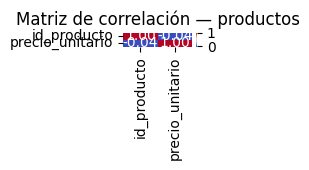


▶ Top correlaciones (|r| más alto):


,,abs(r)
id_producto,precio_unitario,0.03798



🔗 CORRELACIONES — VENTAS


,id_venta,id_cliente
id_venta,1.000000,0.008391
id_cliente,0.008391,1.000000


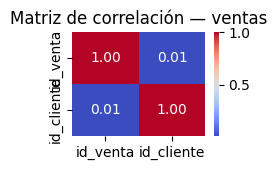


▶ Top correlaciones (|r| más alto):


,,abs(r)
id_venta,id_cliente,0.008391



🔗 CORRELACIONES — DETALLE_VENTAS


,id_venta,id_producto,cantidad,precio_unitario,importe
id_venta,1.000000,-0.042161,0.037559,-0.094872,-0.063107
id_producto,-0.042161,1.000000,0.076373,0.002185,0.048966
cantidad,0.037559,0.076373,1.000000,-0.074483,0.599723
precio_unitario,-0.094872,0.002185,-0.074483,1.000000,0.679298
importe,-0.063107,0.048966,0.599723,0.679298,1.000000


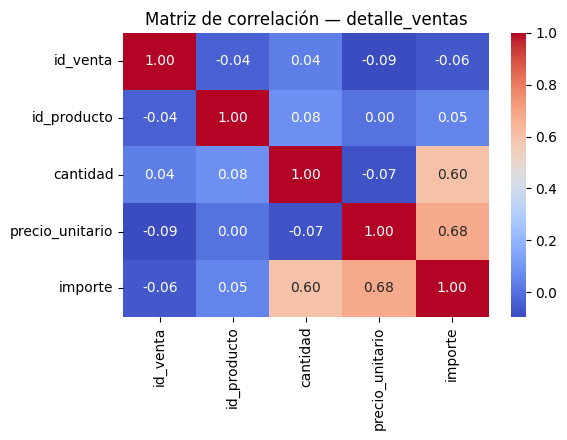


▶ Top correlaciones (|r| más alto):


abs(r)
importe         precio_unitario  0.679298
                cantidad         0.599723
id_venta        precio_unitario  0.094872
cantidad        id_producto      0.076373
precio_unitario cantidad         0.074483
importe         id_venta         0.063107
id_producto     importe          0.048966
                id_venta         0.042161
id_venta        cantidad         0.037559
precio_unitario id_producto      0.002185

In [16]:
for nombre, df in dataframes.items():
    print(f"\n{'='*60}\n🔗 CORRELACIONES — {nombre.upper()}\n{'='*60}")
    num = df.select_dtypes(include=[np.number])
    if num.shape[1] < 2:
        print("⚠️ No hay suficientes columnas numéricas para correlación.")
        continue

    corr = num.corr(numeric_only=True)
    display(corr)

    # Mapa de calor
    plt.figure(figsize=(min(10, 1.2*len(num.columns)), min(8, 0.9*len(num.columns))))
    sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", square=False)
    plt.title(f"Matriz de correlación — {nombre}")
    plt.tight_layout()
    plt.show()

    # Pares con mayor correlación (en valor absoluto), sin duplicados ni diagonal
    corr_pairs = (
        corr.where(~np.eye(corr.shape[0], dtype=bool))
            .abs()
            .stack()
            .sort_values(ascending=False)
    )
    top = corr_pairs.drop_duplicates().head(10)
    if not top.empty:
        print("\n▶ Top correlaciones (|r| más alto):")
        display(top.to_frame("abs(r)"))


Detección de outliers


🚨 OUTLIERS (IQR) — CLIENTES
No hay columnas numéricas válidas (sin IDs).

🚨 OUTLIERS (IQR) — PRODUCTOS


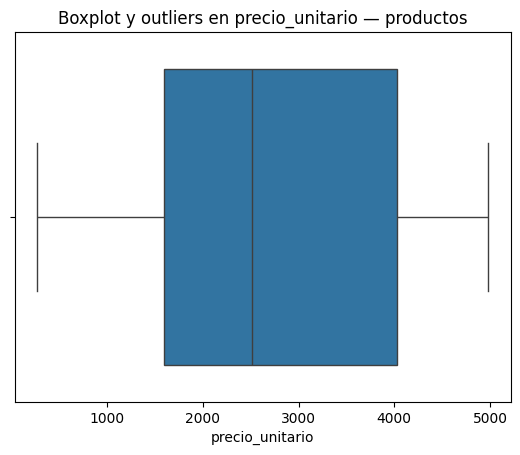


▶ Resumen por columna:


,columna,outliers,lim_inf,lim_sup
0,precio_unitario,0,-2064.75,7681.25


✅ Sin outliers según criterio IQR.

🚨 OUTLIERS (IQR) — VENTAS
No hay columnas numéricas válidas (sin IDs).

🚨 OUTLIERS (IQR) — DETALLE_VENTAS


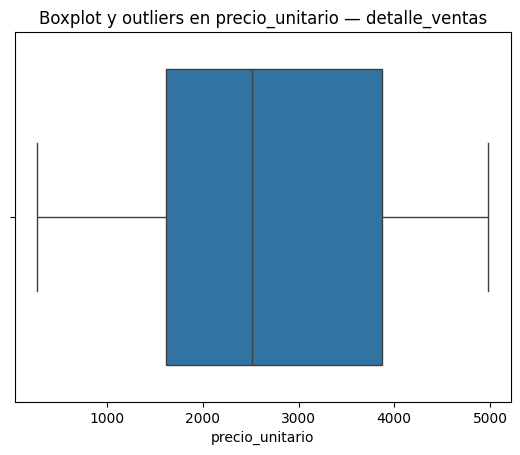

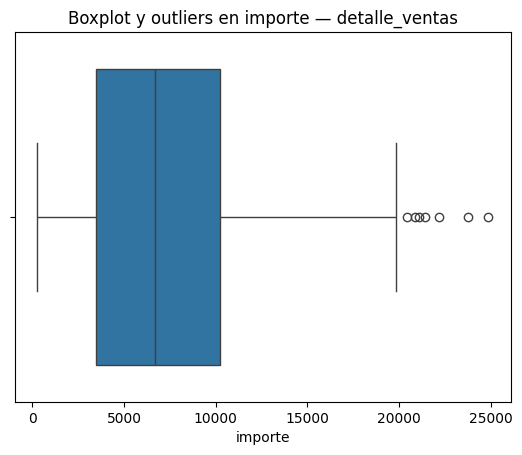


▶ Resumen por columna:


,columna,outliers,lim_inf,lim_sup
1,importe,7,-6624.75,20345.25
0,precio_unitario,0,-1767.75,7262.25



▶ Filas con al menos un outlier (primeras 20):


,id_venta,id_producto,nombre_producto,cantidad,precio_unitario,importe
41,16,35,Barrita de Cereal 30g,5,4430,22150
54,21,76,Pizza Congelada Muzzarella,5,4286,21430
141,50,58,Caramelos Masticables,5,4752,23760
175,63,8,Energética Nitro 500ml,5,4218,21090
208,75,2,Pepsi 1.5L,5,4973,24865
260,94,86,Jugo en Polvo Limón,5,4090,20450
308,110,6,Jugo de Naranja 1L,5,4170,20850


In [17]:
def iqr_outliers(s):
    """Devuelve máscara booleana de outliers y límites inferior/superior según el método IQR."""
    q1 = s.quantile(0.25)
    q3 = s.quantile(0.75)
    iqr = q3 - q1
    lim_inf = q1 - 1.5 * iqr
    lim_sup = q3 + 1.5 * iqr
    mask = (s < lim_inf) | (s > lim_sup)
    return mask, lim_inf, lim_sup

for nombre, df in dataframes.items():
    print(f"\n{'='*60}\n🚨 OUTLIERS (IQR) — {nombre.upper()}\n{'='*60}")

    # ✅ Seleccionamos solo columnas numéricas que no sean IDs
    num_cols = [
        c for c in df.select_dtypes(include=[np.number]).columns
        if "id" not in c.lower()
    ]

    if len(num_cols) == 0:
        print("No hay columnas numéricas válidas (sin IDs).")
        continue

    resumen = []
    outlier_indices_global = set()

    for col in num_cols:
        s = df[col].dropna()
        if s.empty:
            continue

        mask, li, ls = iqr_outliers(s)
        idx = s.index[mask]
        resumen.append({
            "columna": col,
            "outliers": len(idx),
            "lim_inf": li,
            "lim_sup": ls
        })
        outlier_indices_global.update(idx)

        # Boxplot visual
        plt.figure()
        sns.boxplot(x=df[col])
        plt.title(f"Boxplot y outliers en {col} — {nombre}")
        plt.show()

    if resumen:
        print("\n▶ Resumen por columna:")
        display(pd.DataFrame(resumen).sort_values("outliers", ascending=False))

    if outlier_indices_global:
        print("\n▶ Filas con al menos un outlier (primeras 20):")
        display(df.loc[sorted(outlier_indices_global)].head(20))
    else:
        print("✅ Sin outliers según criterio IQR.")

In [18]:
import pandas as pd
import plotly.express as px
import panel as pn

# 1. Instalación (descomentar y ejecutar si es la primera vez)
# !pip install plotly pandas panel

# 2. Activar Panel para su uso en Jupyter
pn.extension()

# Asumo que 'dataframes' está cargado con las claves 'ventas', 'clientes', y 'detalle_ventas'.

# --- 3. FUSIÓN DE DATAFRAMES NECESARIA (CORREGIDO) ---
try:
    # **CORRECCIÓN CLAVE:** La columna de fecha en 'ventas' se llama 'fecha', no 'fecha_venta'.
    # 1. Unir ventas con clientes para obtener la ciudad
    df_ventas_cliente = pd.merge(
        dataframes['ventas'][['id_venta', 'id_cliente', 'fecha']], # <-- CORREGIDO AQUÍ
        dataframes['clientes'][['id_cliente', 'ciudad']],
        on='id_cliente',
        how='left'
    )
    # 2. Unir el resultado con el detalle de ventas para obtener el importe, producto y cantidad
    df_merge_full = pd.merge(
        df_ventas_cliente,
        dataframes['detalle_ventas'][['id_venta', 'importe', 'nombre_producto', 'cantidad']],
        on='id_venta',
        how='left'
    )
    print("✅ Fusión de DataFrames completada (df_merge_full).")
except Exception as e:
    print(f"❌ Error al fusionar DataFrames: {e}")
    raise

# --- 4. GENERACIÓN DE GRÁFICOS INTERACTIVOS (PLOTLY) ---

# A. GRÁFICO: Top 10 Productos Más Vendidos (en Cantidad)
top_productos = (
    df_merge_full.groupby('nombre_producto')['cantidad']
    .sum()
    .nlargest(10)
    .sort_values(ascending=True)
    .reset_index()
)
fig_productos = px.bar(
    top_productos, y='nombre_producto', x='cantidad', orientation='h',
    title='🥇 Top 10 Productos Más Vendidos (Cantidad)', color='cantidad',
    color_continuous_scale=px.colors.sequential.Viridis
).update_layout(yaxis_title="Producto", xaxis_title="Cantidad Vendida")


# B. GRÁFICO: Top 10 Clientes con Mayor Gasto Total
top_clientes = (
    df_merge_full.groupby('id_cliente')['importe']
    .sum()
    .nlargest(10)
    .sort_values(ascending=True)
    .reset_index()
)
fig_clientes = px.bar(
    top_clientes, y='id_cliente', x='importe', orientation='h',
    title='💰 Top 10 Clientes por Gasto Total', color='importe',
    color_continuous_scale=px.colors.sequential.Plasma
).update_layout(yaxis_title="ID Cliente", xaxis_title="Gasto Total ($)")
fig_clientes.update_traces(hovertemplate='Gasto Total: $%{x:.2f}<extra></extra>')


# C. GRÁFICO: Top 10 Ciudades con Más Ventas (en Total)
top_ciudades = (
    df_merge_full.groupby('ciudad')['importe']
    .sum()
    .nlargest(10)
    .reset_index()
)
fig_ciudades = px.pie(
    top_ciudades, names='ciudad', values='importe',
    title='🏙️ Distribución de Ventas por Ciudad (Top 10)',
)
fig_ciudades.update_traces(textposition='inside', textinfo='percent+label')

print("✅ Gráficos Plotly generados exitosamente.")

✅ Fusión de DataFrames completada (df_merge_full).
✅ Gráficos Plotly generados exitosamente.


In [22]:
import pandas as pd
import plotly.express as px
from plotly.offline import plot
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import numpy as np

# Carga de DataFrames (Asegúrate que los archivos estén en la misma carpeta)
try:
    clientes = pd.read_csv('df_clientes_limpio.csv')
    ventas = pd.read_csv('df_ventas_limpio.csv')
    detalle_ventas = pd.read_csv('df_detalle_ventas_limpio.csv')
except Exception as e:
    print(f"❌ Error al cargar archivos CSV: {e}")
    raise

# --- 1. FUSIÓN DE DATAFRAMES Y PREPROCESAMIENTO (CORREGIDO) ---
try:
    # 1.1 Fusión de DataFrames (usando 'fecha' y 'ciudad')
    df_ventas_cliente = pd.merge(
        ventas[['id_venta', 'id_cliente', 'fecha']],
        clientes[['id_cliente', 'ciudad']],
        on='id_cliente',
        how='left'
    )
    df_merge_full = pd.merge(
        df_ventas_cliente,
        detalle_ventas[['id_venta', 'importe', 'nombre_producto', 'cantidad']],
        on='id_venta',
        how='left'
    )
    
    # 1.2 Limpieza de columnas clave
    # Convertir a numérico y manejar NaNs (para evitar el IndexError en el KPI)
    df_merge_full['importe'] = pd.to_numeric(df_merge_full['importe'], errors='coerce').fillna(0.0)
    df_merge_full['cantidad'] = df_merge_full['cantidad'].fillna(0).astype(int)
    
except Exception as e:
    print(f"❌ Error durante la fusión o preprocesamiento: {e}")
    raise


# --- 2. GENERACIÓN DE GRÁFICOS INTERACTIVOS (PLOTLY) ---

# A. Top 10 Productos Más Vendidos (en Cantidad)
top_productos = df_merge_full.groupby('nombre_producto')['cantidad'].sum().nlargest(10).sort_values(ascending=True).reset_index()
fig_productos = px.bar(
    top_productos, y='nombre_producto', x='cantidad', orientation='h',
    color='cantidad', color_continuous_scale=px.colors.sequential.Viridis
)

# B. Top 10 Clientes con Mayor Gasto Total
top_clientes = df_merge_full.groupby('id_cliente')['importe'].sum().nlargest(10).sort_values(ascending=True).reset_index()
fig_clientes = px.bar(
    top_clientes, y='id_cliente', x='importe', orientation='h',
    color='importe', color_continuous_scale=px.colors.sequential.Plasma
)

# C. Top 10 Ciudades con Más Ventas (en Total)
top_ciudades = df_merge_full.groupby('ciudad')['importe'].sum().nlargest(10).reset_index()
fig_ciudades = px.pie(
    top_ciudades, names='ciudad', values='importe',
)


# --- 3. COMBINACIÓN DE GRÁFICOS EN HTML (DASHBOARD) ---

# Cálculo del KPI principal
venta_total_general = df_merge_full['importe'].sum()

# 3.1. Crear la figura de subplots (diseño 2x2: un gráfico grande, dos pequeños)
fig = make_subplots(
    rows=2, cols=2,
    # El gráfico de productos ocupa 2 filas, el de torta usa el tipo 'domain'
    specs=[[{"rowspan": 2, "type": "xy"}, {"type": "domain"}],
           [None, {"type": "xy"}]],
    column_widths=[0.6, 0.4],
    subplot_titles=("🥇 Top 10 Productos Más Vendidos (Cantidad)",
                    "🏙️ Distribución de Ventas por Ciudad (Top 10)",
                    "💰 Top 10 Clientes por Gasto Total")
)

# 3.2. Agregar los traces a los subplots
for trace in fig_productos.data: # A
    fig.add_trace(trace, row=1, col=1)

for trace in fig_ciudades.data: # C
    fig.add_trace(trace, row=1, col=2)

for trace in fig_clientes.data: # B
    fig.add_trace(trace, row=2, col=2)

# 3.3. Actualizar el diseño y agregar el KPI al título
fig.update_layout(
    height=800,
    width=1200,
    showlegend=True,
    title_text=f"## 📈 Dashboard de Estadísticas Clave de Ventas - Venta Total: ${venta_total_general:,.2f}",
    title_x=0.5
)
# Ajuste de ejes
fig.update_yaxes(title_text="Producto", row=1, col=1)
fig.update_xaxes(title_text="Cantidad Vendida", row=1, col=1)
fig.update_yaxes(title_text="ID Cliente", row=2, col=2)
fig.update_xaxes(title_text="Gasto Total ($)", row=2, col=2)


# 3.4. Guardar la figura combinada en un archivo HTML
html_path = "dashboard_ventas_combinado.html"
fig.write_html(html_path)

print(f"\n✅ Dashboard interactivo guardado en: {html_path}")
print("\n¡Descarga el archivo y ábrelo en tu navegador!")

❌ Error al cargar archivos CSV: [Errno 2] No such file or directory: 'df_clientes_limpio.csv'


FileNotFoundError: [Errno 2] No such file or directory: 'df_clientes_limpio.csv'